In [2]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold, KFold

In [3]:
import re

In [4]:
import functools

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

In [6]:
from sklearn.metrics import mean_squared_error

In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [8]:
data_dict = pd.read_excel('Data_Dictionary.xlsx')
data_dict

,Variable,Description
0,reservation_id,Reservation ID
1,booking_date,Date of booking
2,checkin_date,Checkin date recorded at the time of booking
3,checkout_date,Checkout date recorded at the time of booking
4,channel_code,Different channels of booking
5,main_product_code,Type of product a member has purchased
6,numberofadults,Number of adults travelling
7,numberofchildren,Number of children travelling
8,persontravellingid,Type of person travelling
9,resort_region_code,Resort Region


In [9]:
target = 'amount_spent_per_room_night_scaled'

## Preprocessing

In [10]:
test_df[target] = [-1]*len(test_df)

In [11]:
joined = pd.concat([train_df, test_df], axis = 0)

In [12]:
date_time_att = train_df.columns[1:4].values

In [13]:
def add_datepart(df, fldname, drop=True, time=False, errors="raise"):	
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [14]:
joined[date_time_att] = joined[date_time_att].apply(pd.to_datetime)
#.dt.year.apply(lambda x: x if x<2010 else x - 100).apply(int)

In [15]:
for c in date_time_att:
    add_datepart(joined, fldname=c, drop = True)

In [16]:
joined = joined.fillna(-1)

In [17]:
check1 = joined.copy()

In [104]:
joined = check1.copy()

In [105]:
ind = 'reservation_id'

In [106]:
joined = joined.drop(ind, axis = 1)

In [92]:
from sklearn.preprocessing import OrdinalEncoder
categories = ['cluster_code', 'reservationstatusid_code', 'member_age_buckets']
enc = OrdinalEncoder()
enc.fit(joined[categories])

joined[categories] = enc.transform(joined[categories])

for c in categories:
    joined[c] = pd.to_numeric(joined[c], downcast='signed')

In [107]:
joined.head()

,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,...,checkout_Day,checkout_Dayofweek,checkout_Dayofyear,checkout_Is_month_end,checkout_Is_month_start,checkout_Is_quarter_end,checkout_Is_quarter_start,checkout_Is_year_end,checkout_Is_year_start,checkout_Elapsed
0,3,1,2,0,46,3,3,3,1,2.0,...,4,0,155,False,False,False,False,False,False,1528070400
1,1,1,2,0,46,3,3,4,5,2.0,...,16,3,106,False,False,False,False,False,False,1429142400
2,1,1,2,0,47,1,5,4,4,2.0,...,2,5,122,False,False,False,False,False,False,1430524800
3,1,1,2,2,46,2,2,3,5,2.0,...,16,1,167,False,False,False,False,False,False,1434412800
4,1,1,2,0,46,2,2,4,5,2.0,...,19,5,353,False,False,False,False,False,False,1450483200


## FEATURE ENGINEERING

In [108]:
for col in joined.drop(target, axis = 1).columns:
    joined[col+'_counts'] = joined[col].map(joined[col].value_counts())  

In [109]:
vert_ag = ['channel_code', 'main_product_code',  'persontravellingid', 'resort_region_code',
       'resort_type_code', 'room_type_booked_code', 
       'season_holidayed_code', 'state_code_residence',
       'state_code_resort',  'member_age_buckets',
       'booking_type_code', 'memberid', 'cluster_code',
       'reservationstatusid_code', 'resort_id']

num_col = ['numberofadults','numberofchildren', 'roomnights','total_pax']

In [110]:
for m in vert_ag:
    temp = joined.groupby(m, as_index = False).agg({n: ['mean', 'std', 'sum'] for n in num_col})
    temp.columns = [i + j for (i, j) in zip(temp.columns.get_level_values(0), temp.columns.get_level_values(1))]
    joined = joined.merge(temp, how = 'left' , on=m)

In [111]:
# Feature ENGG on numerical

features = num_col

def feat_augment_df(df):
    for feature in features:
        df[f'sq_{feature}'] = df[feature]**2
        df[f'repo_{feature}'] = df[feature].apply(lambda x: 0 if x==0 else 1/x)
    df['min'] = df[features].min(axis=1)
    df['mean'] = df[features].mean(axis=1)
    df['max'] = df[features].max(axis=1)
    df['median'] = df[features].median(axis=1)
    df['std'] = df[features].std(axis=1)
    df['var'] = df[features].var(axis=1)
    df['abs_mean'] = df[features].abs().mean(axis=1)
    df['abs_median'] = df[features].abs().median(axis=1)
    df['abs_std'] = df[features].abs().std(axis=1)
    df['skew'] = df[features].skew(axis=1)
    df['kurt'] = df[features].kurt(axis=1)
    df['sq_kurt'] = df[[f'sq_{feature}' for feature in features]].kurt(axis=1)

In [112]:
feat_augment_df(joined)

In [113]:
for i in num_col:
    for j in num_col:
        if i != j:
            joined[i+'-'+j] = joined[i] - joined[j]
            joined[i+'+'+j] = joined[i] + joined[j]
            joined[i+'*'+j] = joined[i] * joined[j]
            joined[i+'/'+j] = joined[i] * joined['repo_'+j]        

In [114]:
joined.head()

,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,...,total_pax*numberofadults,total_pax/numberofadults,total_pax-numberofchildren,total_pax+numberofchildren,total_pax*numberofchildren,total_pax/numberofchildren,total_pax-roomnights,total_pax+roomnights,total_pax*roomnights,total_pax/roomnights
0,3,1,2,0,46,3,3,3,1,2.0,...,6,1.5,3,3,0,0.0,2,4,3,3.0
1,1,1,2,0,46,3,3,4,5,2.0,...,4,1.0,2,2,0,0.0,-3,7,10,0.4
2,1,1,2,0,47,1,5,4,4,2.0,...,4,1.0,2,2,0,0.0,-2,6,8,0.5
3,1,1,2,2,46,2,2,3,5,2.0,...,4,1.0,0,4,4,1.0,-3,7,10,0.4
4,1,1,2,0,46,2,2,4,5,2.0,...,4,1.0,2,2,0,0.0,-3,7,10,0.4


In [115]:
check2 = joined.copy()

In [250]:
joined = check2.copy()

In [251]:
obj = joined.columns[joined.dtypes == object]

In [252]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

for c in obj:  
    le.fit(joined[c])
    joined[c] = le.transform(joined[c])


In [253]:
train_proc = joined[joined[target] != -1]
test_proc= joined[joined[target] == -1]

In [254]:
# Train test
from sklearn.model_selection import train_test_split

train_back, test_back, _ , y_test = train_test_split(train_proc, train_proc[target], train_size = 0.5)
test_back.drop(target, inplace = True, axis = 1)

train = train_back.copy()
test = test_back.copy()

C:\Users\Soumik\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\Soumik\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [255]:
# train = train_proc.copy()
# test = test_proc.copy()

In [256]:
y = train[target]
train = train.drop([target], axis = 1)
test_proc = test_proc.drop([target], axis = 1)

In [257]:
y = y**(103/40)

# Models

### CATBOOST

In [258]:
from catboost import CatBoostRegressor, Pool

In [259]:
cat_boost = CatBoostRegressor(iterations=700,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100, 
                             task_type = "GPU")

In [260]:
cat_boost.fit(train, y, verbose = False, cat_features=vert_ag)

In [261]:
preds = cat_boost.predict(test, 
        ntree_start=0, 
        ntree_end=0, 
        thread_count=-1,
        verbose=None)

np.sqrt(mean_squared_error(y_test, preds**(40/103)))

0.973172598585937

### ANALYSIS

In [124]:
feature_score = pd.DataFrame(list(zip(train.dtypes.index, cat_boost.get_feature_importance(Pool(train, label=y, cat_features=vert_ag)))),
                columns=['Feature','Score'])

Dataset is provided, but PredictionValuesChange feature importance don't use it, since non-empty LeafWeights in model.


In [125]:
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

In [ ]:
feature_score.Feature[:10]

In [45]:
train['checkin_Is_year_start'].value_counts()

False    170107
True        605
Name: checkin_Is_year_start, dtype: int64

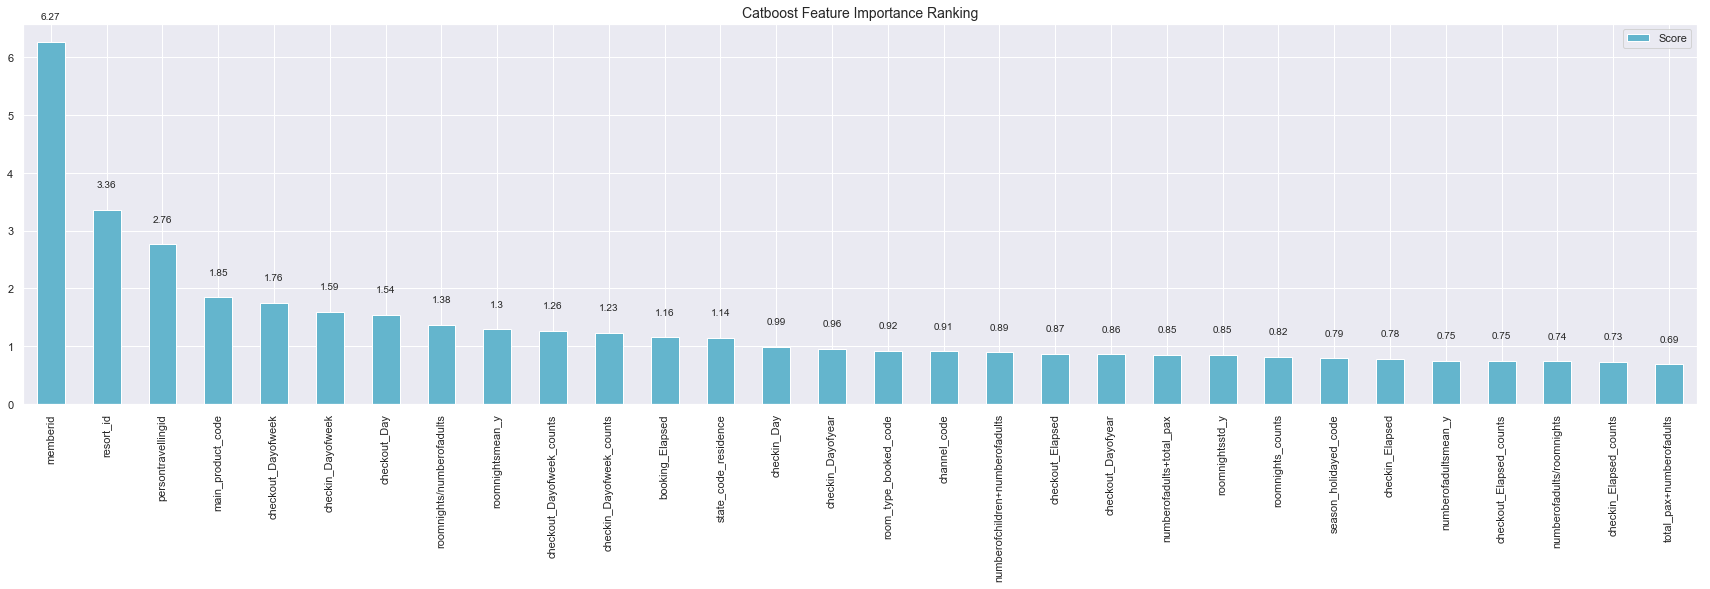

In [126]:
plt.rcParams["figure.figsize"] = (30,7)
ax = feature_score[:30].plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

# get feature score as labels round to 2 decimal
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [381]:
feature_score['Score'].median()

1.134952605537272

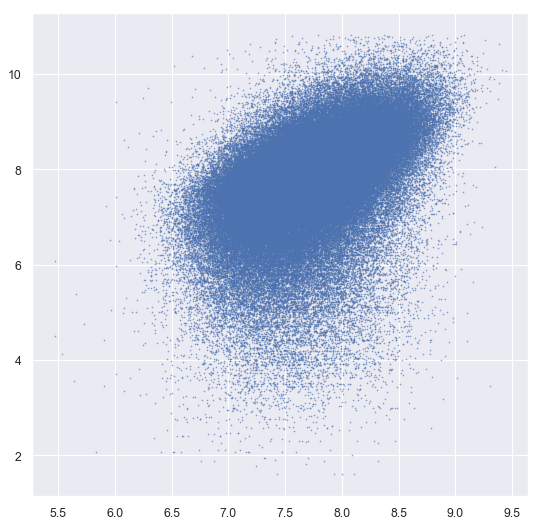

In [127]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(preds, y_test, s = 0.1)

In [50]:
test['diff'] = abs(y_test - preds)

(array([   71.,   405.,  1493.,  3809.,  9403., 25061., 60636., 54563.,
        13741.,  1530.]),
 array([ 1.60943791,  2.53007259,  3.45070727,  4.37134195,  5.29197664,
         6.21261132,  7.133246  ,  8.05388068,  8.97451536,  9.89515004,
        10.81578472]),
 <a list of 10 Patch objects>)

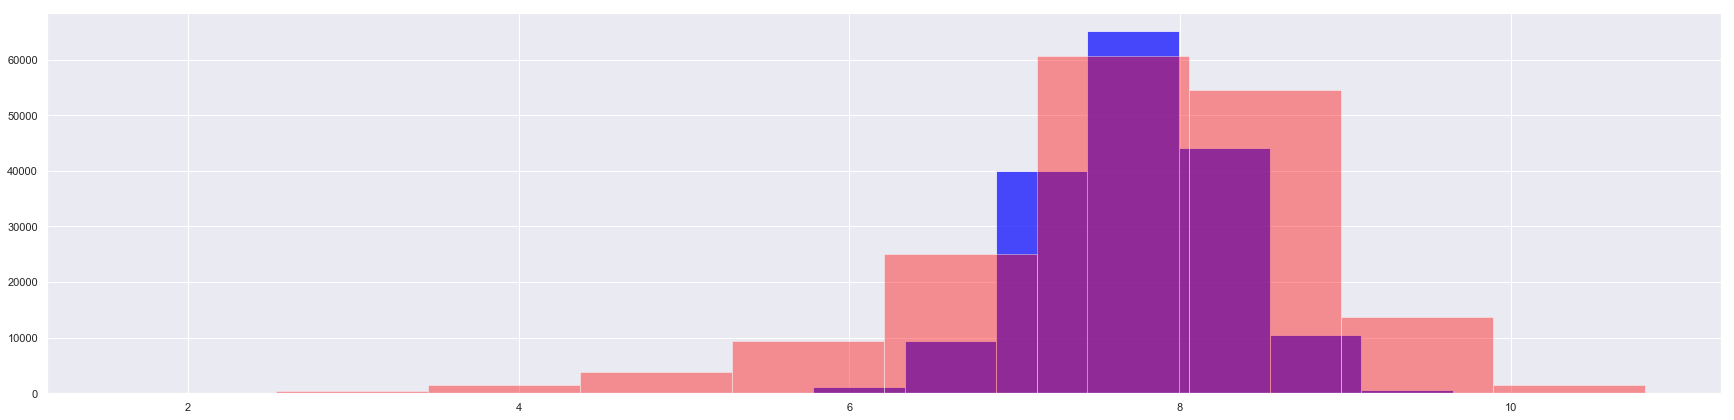

In [59]:
plt.hist(preds, alpha=0.7, color='blue', bins=10)
plt.hist(y_test, alpha=0.4, color='red', bins=10)

In [132]:
feat = feature_score['Feature'][:30]
# test[feat].hist(figsize=(20, 20))

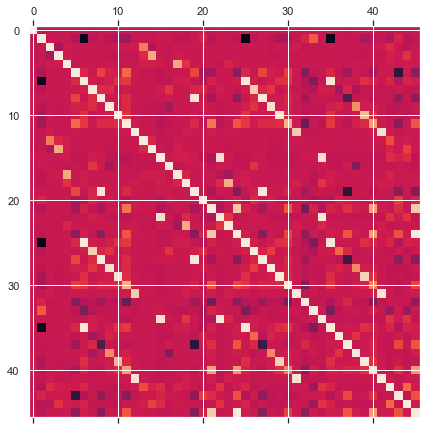

In [136]:
plt.matshow(train[feat].corr())
plt.show()

In [141]:
corr = train[feat].corr()

In [168]:
train[train.columns[0]].dtype

dtype('int64')

In [551]:
checkin_dt.head()

41      2012-04-20
57      2012-04-28
5215    2015-01-01
12275   2015-01-01
66      2015-01-01
Name: checkin_date, dtype: datetime64[ns]

## LGBM

In [186]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'rmse',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'regression', 
    'verbosity': -1
}

In [187]:
trn_data = lgb.Dataset(train, label=y)
clf = lgb.train(param, trn_data, 10000)
pred = clf.predict(test)

## Analysis

In [247]:
y.skew() , (y**(103/40)).skew(), np.cbrt(y).skew()

(-0.916823258889611, -0.00038680408779822613, -1.4734219493962253)

In [188]:
np.sqrt(mean_squared_error(y_test, preds))

1.1891010085689013

In [538]:
#CatBoost submission
submission = test_df[['reservation_id', 'amount_spent_per_room_night_scaled']]
submission.head(2)

,reservation_id,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,-1
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,-1


In [539]:
#LGBM submission
submission['amount_spent_per_room_night_scaled'] = preds
submission.head(2)

C:\Users\Soumik\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,reservation_id,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,8.153924
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,7.625183


In [570]:
len(test)

34143

In [540]:
filename="{:%Y-%m-%d_%H_%M}_sub.csv".format(datetime.now())
submission.to_csv(filename, index=False)

In [175]:
from sklearn.preprocessing import OrdinalEncoder

In [217]:
categories = ['cluster_code', 'reservationstatusid_code', 'member_age_buckets']
enc = OrdinalEncoder()
enc.fit(train[categories])

train[categories] = enc.transform(train[categories])
test[categories] = enc.transform(test[categories])

for c in categories:
    train[c] = pd.to_numeric(train[c], downcast='signed')
    test[c] = pd.to_numeric(test[c], downcast='signed')

C:\Users\Soumik\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Soumik\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Soumik\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

In [205]:
train[categories].nunique()

cluster_code                 6
reservationstatusid_code     4
member_age_buckets          10
dtype: int64

In [206]:
test[categories].nunique()

cluster_code                 6
reservationstatusid_code     3
member_age_buckets          10
dtype: int64

In [207]:
for c in categories:
    print(c)
    print(train[c].value_counts())
    print(test[c].value_counts())

cluster_code
5    120623
4     59830
3     55883
2     37809
1     37669
0     29610
Name: cluster_code, dtype: int64
F    52147
E    25531
D    24245
B    15957
C    15795
A    13090
Name: cluster_code, dtype: int64
reservationstatusid_code
0    312481
1     14811
2     14131
3         1
Name: reservationstatusid_code, dtype: int64
A    134262
B      6429
C      6074
Name: reservationstatusid_code, dtype: int64
member_age_buckets
3    67618
4    66701
5    50967
2    45192
7    38548
6    36082
1    19430
8     8454
0     7054
9     1378
Name: member_age_buckets, dtype: int64
E    28941
D    28334
F    22230
C    19584
H    16115
G    15919
B     8130
I     3601
A     3262
J      649
Name: member_age_buckets, dtype: int64


In [571]:
142/567

0.25044091710758376

In [67]:
t = test_df['channel_code'].values != test_proc['channel_code'].values
t.sum()

0

# Ridge 

In [300]:
from sklearn.linear_model import LassoLarsCV

In [285]:
drop_col = train.columns[train.isna().sum(axis = 0)>0]
train = train.drop(drop_col, axis = 1)

In [301]:
lin = LassoLarsCV()
lin.fit(train.values, y.values)

C:\Users\Soumik\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Soumik\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=8.184e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Soumik\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.220e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  Converge

C:\Users\Soumik\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 66 iterations, i.e. alpha=1.561e-03, with an active set of 64 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Soumik\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 71 iterations, i.e. alpha=1.416e-03, with an active set of 67 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Soumik\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 107 iterations, i.e. alpha=7.098e-04, with an active set of 89 regressors, and the smallest chol

C:\Users\Soumik\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 173 iterations, i.e. alpha=3.371e-04, with an active set of 111 regressors, and the smallest cholesky pivot element being 7.814e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Soumik\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 173 iterations, i.e. alpha=3.371e-04, with an active set of 111 regressors, and the smallest cholesky pivot element being 8.625e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Soumik\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:337: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 174 iterations, alpha=3.371e-04, previou

C:\Users\Soumik\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 80 iterations, i.e. alpha=9.847e-04, with an active set of 68 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Soumik\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 120 iterations, i.e. alpha=5.042e-04, with an active set of 92 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Soumik\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 120 iterations, i.e. alpha=5.042e-04, with an active set of 92 regressors, and the smallest cho

LassoLarsCV(copy_X=True, cv='warn', eps=2.220446049250313e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=None,
      normalize=True, positive=False, precompute='auto', verbose=False)

In [303]:
pred = lin.predict(test.values)

In [309]:
(lin.coef_ != 0).sum()

93

In [308]:
np.sqrt(mean_squared_error(y_test, pred**(40/103)))

1.0286703157133728

In [290]:
train.shape, y.shape

((170712, 336), (170712,))

In [273]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(train.dtypes)

channel_code                          int64
main_product_code                     int64
numberofadults                        int64
numberofchildren                      int64
persontravellingid                    int64
resort_region_code                    int64
resort_type_code                      int64
room_type_booked_code                 int64
roomnights                            int64
season_holidayed_code               float64
state_code_residence                float64
state_code_resort                     int64
total_pax                             int64
member_age_buckets                    int32
booking_type_code                     int64
memberid                              int32
cluster_code                          int32
reservationstatusid_code              int32
resort_id                             int32
booking_Year                          int64
booking_Month                         int64
booking_Week                          int64
booking_Day                     